# __Lecture 09: Practical analyses in Python (continued)__

----
#### __Announcement:__ Homework 4 will be finalized by the end of the day today (I will post on Slack when it's ready). It will be due on Nov 3

#### On Tuesday, we talked about:
- how to define functions in python
- the `re` module

#### Today we will:
- practice using the `re` module
- learn about (and practice) using the `biopython` module
- (if time) start learning about the `pandas` module

###  
----

## __Review:__ Regular expressions

The `re` module offers a set of functions that allows us to search a string for a match. 
Here is the general format for searching for a pattern in a string:

```
import re
string = "This is an example string"

# compile the search pattern
search_pattern = re.compile("search pattern here")

# search for the search pattern in the string
search_pattern.search(string)
```

Here are some common elements to have in your search pattern:
* letter characters which returns a match where the string contains the specified letter (e.g. `A`, `B`, `C`, ...)
* special characters which returns a match where the string contains the specified special character; these must be preceded by a `\`
* `\d` which returns a match where the string contains digits (numbers from `0`-`9`)

You may also want to add the following customizations:
* `[]` specifies a set of characters to search for (e.g. `[a-n]`)
* `()` capture and group everything contained inside, and search the string for everything together
* `?P<name>` indicates a search pattern group with name `name`
* `+` specifies one or more occurrences of a certain pattern element
* `{}` specifies exactly the specified number of occurrences of a certain pattern element
* `$` specifies the end of the string
* `^` specifies the beginning of the string

Here is our influenza example from Tuesday.
Say you download some strains from the database, and they have names that look like this:

In [43]:
strain1 = 'A/New York/3/1994 (H3N2)'
strain2 = 'A/California/3/X/2003 (H12N1)'
strain3 = 'A/Perth/2009 (H3N2)'

strains = [strain1, strain2, strain3]

You want to get some information out of these, like the subtype. 
Let's build a regular expression that gets only the subtype out and then use a dictionary to count how many sequences there are of each subtype:

In [44]:
import re

# compile a re for the subtype (with a named search pattern)
strainmatch = re.compile(
        '\((?P<subtype>H\d+N\d+)\)$')   
    
subtype_counter = {}  # dict to store the results

for strain in strains:  # loop over all strains
    # search for re in each strain
    m = strainmatch.search(strain)
    # isolate named pattern
    subtype = m.group('subtype')
    # add pattern/count to dictionary
    if subtype in subtype_counter:
        subtype_counter[subtype] += 1
    else:
        subtype_counter[subtype] = 1
        
print(subtype_counter)

{'H3N2': 2, 'H12N1': 1}


## __Practice time:__ using regular expressions to parse barcodes
Now we will use regular expressions to parse barcodes from nucleotide sequences.
For instance, you might have to do this in a single-cell RNA-seq experiment where there is a barcode at the end of each read telling you the cell that the read came from.

Imagine that our valid molecules should have sequences like this:

`CTAGCNNNNNNGATCA`

See how there is a 6-nucleotide barcode in the center of the sequence.
We have a list of sequences, and want to parse through them to figure out which ones meet the expected pattern--and get the barcode from those that do:

In [45]:
seqs = ['CTAGCatcgatGATCA',  # has barcode ATCGAT
        'CCAGCatagcaGATCA',  # does not have expected 5' sequence
        'CTAGCtacagGATCA',   # barcode too short
        'CTAGCgaccatGATCA',  # has barcode GACCAT
        'CTAGCatcgatGATCA',  # has barcode ATCGAT
        'CTAGCatcgatGGTCA',  # does not have expected 3' sequence
        ]

Write a function that parses these barcoded sequences and gets the ones with valid barcodes.
In doing this, note that:

  1. If you have a string `s`, `s.upper()` makes it all uppercase.
  2. You may want to start searching at the beginning of the string (using the `^` symbol in the search pattern)
    
Below I've written the function documentation, try to implement it.
__Take a few minutes in groups to work through this.__

In [46]:
def count_barcodes(seqs, bclen=6, upstream='CTAGC', downstream='GATCA'):
    """Parse and count barcodes.
    
    Parameters
    ----------
    seqs : list
        DNA sequences.
    bclen : int
        Length of barcode
    upstream : str
        Sequence upstream of barcode.
    downstream : str
        Sequence downstream of barcode.
        
    Returns
    -------
    dict
        Keyed by each valid barcode, value is number of times the barcode
        is observed.
        
    Note
    ----
    The function is **not** case-sensitive, and all barcodes are reported
    in upper-case.
    
    """
    
    # compile our re
    barcode_re = re.compile(upstream + "(?P<barcode>[ATCG]{" + str(bclen) + "})" + downstream)
    
    barcode_counts = {} 
    
    for seq in seqs:
        seq = seq.upper()
        
        match = barcode_re.search(seq)
        
        if match: # check if there is a match
            barcode = match.group("barcode")
            if barcode in barcode_counts:
                barcode_counts[barcode] += 1
            else:
                barcode_counts[barcode] = 1
        
    return barcode_counts


Run the function once you've implemented it. Does it give the right result?

In [47]:
count_barcodes(seqs)

{'ATCGAT': 2, 'GACCAT': 1}

## Biopython
[Biopython](https://biopython.org/) is a package that has lots of useful functions for computational biology.

It is very handy for things like reading in sequences in many different formats: the subpackage [Bio.SeqIO](https://biopython.org/wiki/SeqIO) is your friend!

(Do note that if you are analyzing truly large datasets, `Biopython` is not very fast and you may want to use something like [pysam](https://pysam.readthedocs.io/en/latest/api.html); but `Biopython` is a good starting point).

### Reading in a file
I have included the file [barcodes_R1.fastq](barcodes_R1.fastq), which has some FASTQ sequences in it.

Let's use `Biopython` to read the FASTQ entries.

First, we'll need to import `Biopython.SeqIO`

In [48]:
import re

import Bio.SeqIO

Now read in the sequencing reads:

In [49]:
seqreads = list(Bio.SeqIO.parse('barcodes_R1.fastq', format='fastq'))

How many reads were there?

In [50]:
print(f"Found {len(seqreads)} sequencing reads.")

Found 10000 sequencing reads.


Let's look at the first read:

In [51]:
seqreads[0]

SeqRecord(seq=Seq('GCTTAAGTTATTTAGTGCGGCCGCCTATGGTGCACTATTATTTATCTATCGTGA...AGA'), id='HISEQ:621:HMJGNBCX2:1:1101:1797:2150', name='HISEQ:621:HMJGNBCX2:1:1101:1797:2150', description='HISEQ:621:HMJGNBCX2:1:1101:1797:2150 1:N:0:ATGTCA', dbxrefs=[])

You can see that `BioPython` reads the sequences in as [SeqRecord](https://biopython.org/wiki/SeqRecord) objects, which have a lot of information, including the header, quality scores, etc.

For our purposes, we will just convert the sequence part into a string for each sequence:

In [52]:
seqreads_str = []
for seqrecord in seqreads:
    sequence = str(seqrecord.seq) # convert sequence part to string
    seqreads_str.append(sequence) # add string sequence to list

Make sure we still have the same number of sequencing reads, and look at the first one:

In [53]:
assert len(seqreads_str) == len(seqreads)

seqreads_str[0]

'GCTTAAGTTATTTAGTGCGGCCGCCTATGGTGCACTATTATTTATCTATCGTGAAAGGGAGTTCTGCTCCATCAGGCCAAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATGTCAGAATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAAAGCTGAAATTAATAATTTTGAAACCAGTTTTGTAAACGCAGCACTAAAATGAAGGCATGCAACGACGATGTTTATTGACACGGAATAGCAGA'

## A real biological analysis: parsing barcodes
<a id='real_analysis'></a>
The reads that we just read as `seqreads_str` come from a real sequencing run of influenza virus HA and NA genes.

The sequences are as follows:

    5'-[end of HA]-AGGCGGCCGC-[16 X N barcode]-3'
    
or 

    5'-[end of NA]-AGGCGGCCGC-[16 X N barcode]-3'
    
The end of NA is:

    ...CACGATAGATAAATAATAGTGCACCAT
    
The end of HA is:

    ...CCGGATTTGCATATAATGATGCACCAT
    
The sequencing run reads from the reverse end of the molecules (in 5'>3' orientation), so the first thing in the sequencing reads is the reverse complement of the barcode followed by the constant sequence and the end of HA or NA.

We want to determine which reads have valid sequences, get the barcodes out of strings, and count the barcodes.
So this requires setting up an analysis that does the following:

 1. Get the reverse complement of each read.
 2. Determine if it matches the expected pattern (with the correct length barcode and constant sequence)
 3. If it matches, extract the barcode and add it to a dictionary to keep track of counts.

### Group activity
In groups, work together to write some code to do this.
I have created a code chunk for each step (with some parts filled in). 
Remember to run the code chunks in the correct order!

For your homework, you will be asked to extend this in-class analysis to get statistics for HA and NA seperately.

In [54]:
# load necessary packages
import re
import Bio.SeqIO

__Step 1:__ You'll need two functions: (1) a function that gets the reverse complement of a DNA sequence and (2) a function that identifies a barcode with a known upstream sequence. 
We went over (1) on Tuesday, and I've copied it over here. 
I've provided the documentation for (2) here--try writing this function on your own.

_Hint: we wrote a similar function earlier today_

In [55]:
def reverse_complement(seq, unk_partner = 'N'):
    """Get reverse complement of a DNA sequence.
    
    Parameters
    -----------
    seq : str
        Uppercase DNA sequence.
        
    Returns
    -------
    str
        Reverse complement of the sequence in upper case.
        
    Example
    --------
    >>> reverse_complement('ATGCAC')
    'GTGCAT'
    
    """
    base_partner = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}
    rseq = ''
    for a in seq:
        if a in base_partner:
            # look up the complementary base in the dictionary
            pair = base_partner[a]
            rseq = pair + rseq
        else:
            rseq = unk_partner + rseq
    return rseq

In [56]:
rev = []

for seq in seqreads_str:
    reverse_complement(seq)
    rev.append(reverse_complement(seq))
#print(rev)


In [57]:
' '.join(rev)

'TCTGCTATTCCGTGTCAATAAACATCGTCGTTGCATGCCTTCATTTTAGTGCTGCGTTTACAAAACTGGTTTCAAAATTATTAATTTCAGCTTTTTTTTTTTTTTCAAGCAGAAGACGGCATACGAGATTCTGACATGTGACTGGAGTTCAGACGTGTGCTCTTCCGATCTTGGCCTGATGGAGCAGAACTCCCTTTCACGATAGATAAATAATAGTGCACCATAGGCGGCCGCACTAAATAACTTAAGC TCGTACACTCTGTCATTAGGGATGTATTTGTTTAATGCATGGGGTTGTATACTAAGCTGTTGATGGTGTCTTTATGATACCTATTTAGGTTTTTTTTTTTTTTTTCAAGCAGAAGACGGCATACGAGATTCTGACATGTGACTGGAGTTCAGACGTGTGCTCTTCCGATCTATGTGTTCCAACGGCTCCTTGCAATGCCGGATTTGCATATAATGATGCACCATAGGCGGCCGCAACCGTGACCAGGAAG TCGTAGTGTATAGTAGAAGGGACGTCTACGTTAATCAGTGTCATAAGTTCGATCATTGGCTTCAATACCTAGTGGGAGTTAGATTTTGTATGTTAGTTTTTTTTTTCAAGCAGAAGACGGCATACGAGATTCTGACATGTGACTGGAGTTCAGACGTGTGCTCTTCCGATCTTGGCCTGATGGAGCAGAACTCCCTTTCACGATAGATAAATAATAGTGCACCATAGGCGGCCGCGGGGTAATAGCCGTG TCAGATGAATGGTAGTTGGTGATAGCATGAGGTTGGGTCGGATGGTTAGTGTCTTCTTTCATCTGATGGTTGTGTTTTGCGTGCTTTGCTTTTTTTTTTTTTTTTCAAGCAGAAGACGGCATACGAGATTCTGACATGTGACTGGAGTTCAGACGTGTGCTCTTCCGATCTATGTGTTCCAACGGCTCCTTGCAATGCCGGATTTGCATATAATGATGCAACATAGGCGGCCGCCCACATTCATCG

In [85]:
def count_prot(seqs, protlen=27, upstream='AGGCGGCCGC'): #this is to correct orientation of the seq to look for in rev 
    
    # compile our re
    prot_re = re.compile("(?P<prot>[ATCG]{" + str(protlen) + "})"+ upstream)
    
    NA = 'CACGATAGATAAATAATAGTGCACCAT'
    HA = 'CCGGATTTGCATATAATGATGCACCAT'
    prot_counts = {'NA_counts':0, 'HA_counts':0, 'neither':0} 
    
    for seq in seqs:
        match = prot_re.search(seq)
        
        if match: # check if there is a match
            prot = match.group("prot")
            if prot == NA:
                prot_counts["NA_counts"] +=1
            elif prot == HA:
                prot_counts["HA_counts"] += 1
            else:
                prot_counts["neither"] += 1
        
    return prot_counts

    print(prot_counts)

    #gus and ariana

In [81]:
count_prot(rev)

{'NA_counts': 3973, 'HA_counts': 5316, 'neither': 251}

In [60]:
def read_barcode(seqread, bclen, upstream='AGGCGGCCGC'):
    """Identify barcode with known upstream sequence.
    
    Parameters
    ----------
    seqread : str
        Nucleotide sequence matching UPSTREAM-BARCODE read in reverse orientation.
    bclen : int
        Length of barcode
    upstream: str
        Sequence upstream of the barcode.
        
    Returns
    -------
    str or None
        Sequence of the barcode in the forward orientation, or `None` if no match to expected barcoded sequence.
        
    Example
    -------
    >>> read_barcode('TTTTTTTTTTTTTTTTGCGGCCGCCT', bclen=16)
    'AAAAAAAAAAAAAAAA'
        
    """
    # get the reverse complement of the read
    reverse = reverse_complement(seqread)
    
    # compile the barcode search pattern
    barcode_pattern = re.compile(upstream + f"(?P<barcode>[ATCGN]{{{bclen}}})$")
    
    # search for the barcode pattern
    match = barcode_pattern.search(reverse)
    
    if match:
        barcode = match.group('barcode')
        return barcode
    else:
        return None

__Step 2:__ Read sequences _(note: we already did this step earlier)_

In [61]:
# run this code chunk...
seqreads = list(Bio.SeqIO.parse('barcodes_R1.fastq', 'fastq'))

seqreads_str = []
for seqrecord in seqreads:
    seqreads_str.append(str(seqrecord.seq))

__Step 3:__ Get the counts of all barcodes. _(Hint: you might want to store barcodes and counts in a dictionary, and also keep track of the number of sequences that don't have a valid barcode)_

Please name your dictionary `barcode_counts`

In [62]:
barcode_counts = {}
n_invalid = 0

for seq in seqreads_str: # iterate through all reads
    barcode = read_barcode(seq, bclen = 16)
    if barcode: # if there is a valid barcode, add it to the dictionary
        if barcode in barcode_counts:
            barcode_counts[barcode] += 1
        else:
            barcode_counts[barcode] = 1
    else: # otherwise, add it to the count of invalid reads
        n_invalid += 1


__Step 4:__ Report the total number of sequences parsed, and how many lacked a valid barcode.

In [63]:
print(f"There were {len(seqreads_str)} total sequence reads parsed, and {n_invalid} lacked a valid barcode.")

There were 10000 total sequence reads parsed, and 549 lacked a valid barcode.


## __We did not get to the rest of this lecture in class..__
----
## Creating a data frame with the barcode counts
We create a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) with the barcode counts.
These data frames are a great way to represent any information that can ultimately be thought of in tabular form.

In [64]:
import pandas

barcode_counts_df = pandas.Series(barcode_counts).reset_index()

barcode_counts_df.columns = ['barcode', 'count']

barcode_counts_df

,barcode,count
0,ACTAAATAACTTAAGC,63
1,AACCGTGACCAGGAAG,70
2,CCACATTCATCGCTGA,30
3,TTATCGTCTCCCATAT,78
4,CTACCCGTTTCCCAAC,124
...,...,...
450,ATTGCATGACTACAAC,1
451,TTACGATCCTCAAGAA,1
452,GCACATAAGGAGCCAA,1
453,AATACGAACATATCGG,1


Looking at a few entries in a data frame: the [head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) commands:

In [66]:
barcode_counts_df.tail()

,barcode,count
450,ATTGCATGACTACAAC,1
451,TTACGATCCTCAAGAA,1
452,GCACATAAGGAGCCAA,1
453,AATACGAACATATCGG,1
454,GCTACTACTATACCTT,1


Sorting a data frame: the [sort_values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) command:

In [67]:
barcode_counts_df.sort_values('count', ascending=False)

,barcode,count
31,CCCGACCCGACATTAA,158
49,ACCAGTTCTCCCCGGG,154
27,TCAAGAAGCCTTGGAG,152
48,TGACGATCCTCAAGAA,145
8,CGTCTTCCATCCCCAT,136
...,...,...
286,AATACGAGCATCTCGG,1
287,TAACACTTATGGCAAC,1
289,CGTCATAGAGAAGGTT,1
290,ACGAGAGGCCGACTCG,1


### Plotting the data frame
Python has lots of ways to make plots:

 - [matplotlib](https://matplotlib.org/): The base Python plotting library, you can do almost anything with it.
 - [seaborn](https://seaborn.pydata.org/): Useful to easily make certain kinds of complex scientific plots.
 - [Altair](https://altair-viz.github.io/): Developed at University of Washington, great for making **interactive** plots.
 
We aren't going to use any of those, but feel free to explore them on your own--instead we are going to [plot directly from pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)
This is a useful strategy if you have a data frame and need a quick and simple plot.

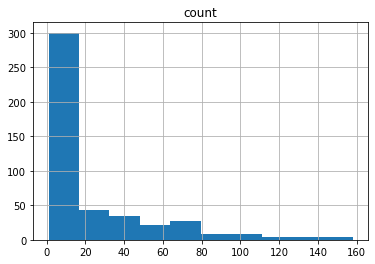

In [68]:
# use pandas built in plotting

fig = barcode_counts_df.hist('count')

### Faceting the plot
What if we had barcode counts for several **different** categories (such as genes)?

Here we do this on made up data, where we simply imagine that our same data multiplied by two is a second category.

First, we now make a merged data frame with the original data and the data multiplied by two.
Note how we do this using the [pandas.concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) function, and how we use [assign](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html) to add the dummy variable to each data frame:

In [69]:
copy1 = barcode_counts_df.assign(dummy_variable='category_1')
copy2 = barcode_counts_df.assign(dummy_variable='category_2')

dummy_df = pandas.concat([copy1, copy2]).reset_index(drop=True)

dummy_df

,barcode,count,dummy_variable
0,ACTAAATAACTTAAGC,63,category_1
1,AACCGTGACCAGGAAG,70,category_1
2,CCACATTCATCGCTGA,30,category_1
3,TTATCGTCTCCCATAT,78,category_1
4,CTACCCGTTTCCCAAC,124,category_1
...,...,...,...
905,ATTGCATGACTACAAC,1,category_2
906,TTACGATCCTCAAGAA,1,category_2
907,GCACATAAGGAGCCAA,1,category_2
908,AATACGAACATATCGG,1,category_2


Now facet the plot using the `by` argument:

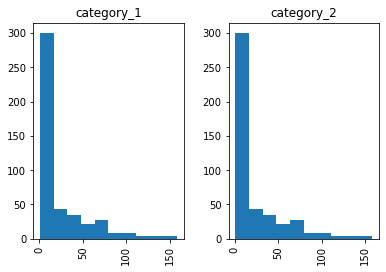

In [70]:
fig2 = dummy_df.hist('count', by = 'dummy_variable')

# Homework 4: Practical analysis with BioPython

For the homework, you are going to extend the code from the analysis of our FASTQ file in lectures 8 and 9.
Recall that the FASTQ file contains reads from a real sequencing run of influenza virus HA and NA genes.

The _actual sequences_ are as follows:

    5'-[end of HA]-AGGCGGCCGC-[16 X N barcode]-3'
    
or 

    5'-[end of NA]-AGGCGGCCGC-[16 X N barcode]-3'
    
The end of NA is:

    ...CACGATAGATAAATAATAGTGCACCAT
    
The end of HA is:

    ...CCGGATTTGCATATAATGATGCACCAT
    
The _sequencing reads_ (located in the FASTQ file) are from the reverse end of these actual sequences, so the first thing in the sequencing reads is the reverse complement of the barcode followed by the reverse complement of the constant sequence, etc.
The reads can originate from **either** HA or NA, and that will be distinguished by the most 3' end of the read.
But in our example exercise in class, we did not distinguish among reads matching to HA and NA, as we didn't even look far enough into the read to tell the identity.

For the homework, your goal is to write code that extends the material from lectures 8 and 9 to also distinguish between HA and NA.
This homework can be completed almost entirely by re-using code from lecture 9. You will need to set up your analysis to do the following:
 1. Get the reverse complement of each read.
 2. Determine if it matches the expected pattern for HA and NA, and if so which one.
 3. If it matches, extract the barcode and add it to a dictionary to keep track of counts.
 4. Determine the number and distribution of barcodes for HA and NA separately.

Please include code to address each of the following questions. Please include code comments to explain what your code is attempting to accomplish. Don't forget to include references to the sources you used to obtain your answer, including your classmates (if you are working in groups).  

1. How many reads map to HA, and how many reads map to NA?

In [71]:
#Cells 17-24

2. What is the HA barcode with the most counts (and how many counts)? Also answer the same question for NA.

    _Hint: you will need to find the key associated with the maximum value in your dictionary. There are many ways to do this._

In [87]:
max(NA_counts, key=len)




'N'